In [2]:
import os
from pathlib import Path
project_root = os.path.join('/home/shashank/research/qd/main/diffusion_models')
os.chdir(project_root)
%pwd # should be PPGA root dir

'/home/shashank/research/qd/main/diffusion_models'

In [3]:
import torch
import pickle
import json
import numpy as np
import matplotlib
matplotlib.rcParams.update(
    {
        "figure.dpi": 150,
        "font.size": 20,
    }
)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
import matplotlib.pyplot as plt

from typing import Optional
from diffusion.gaussian_diffusion import cosine_beta_schedule, linear_beta_schedule, GaussianDiffusion
from diffusion.latent_diffusion import LatentDiffusion
from diffusion.ddim import DDIMSampler
from autoencoders.policy.hypernet import HypernetAutoEncoder as AutoEncoder
from dataset.shaped_elites_dataset import WeightNormalizer
from attrdict import AttrDict
from utils.tensor_dict import TensorDict, cat_tensordicts
from RL.actor_critic import Actor
from utils.normalize import ObsNormalizer
from models.cond_unet import ConditionalUNet, LangConditionalUNet
from envs.brax_custom.brax_env import make_vec_env_brax
from IPython.display import HTML, Image
from IPython.display import display
from brax.io import html, image
from utils.brax_utils import shared_params, rollout_many_agents

/home/shashank/miniconda3/envs/qd/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# params to config
device = torch.device('cuda')
env_name = 'humanoid'
seed = 1111
normalize_obs = True
normalize_rewards = False
obs_shape = shared_params[env_name]['obs_dim']
action_shape = np.array([shared_params[env_name]['action_dim']])
mlp_shape = (128, 128, action_shape)

env_cfg = AttrDict({
    'env_name': env_name,
    'env_batch_size': None,
    'num_dims': 2,
    'seed': seed,
    'num_envs': 1,
    'clip_obs_rew': True,
})

In [5]:
archive_df_path = f'data/{env_name}/archive100x100.pkl'
with open(archive_df_path, 'rb') as f:
    archive_df = pickle.load(f)

# scheduler_path = f'data/{env_name}/scheduler_100x100.pkl'
# with open(scheduler_path, 'rb') as f:
#     scheduler = pickle.load(f)

In [6]:
# make the env
env = make_vec_env_brax(env_cfg)

In [7]:
def enjoy_brax(agent, render=True, deterministic=True):
    if normalize_obs:
        obs_mean, obs_var = agent.obs_normalizer.obs_rms.mean, agent.obs_normalizer.obs_rms.var
        print(f'Normalize Obs Enabled')

    obs = env.reset()
    rollout = [env.unwrapped._state]
    total_reward = 0
    measures = torch.zeros(env_cfg.num_dims).to(device)
    done = False
    while not done:
        with torch.no_grad():
            obs = obs.unsqueeze(dim=0).to(device)
            if normalize_obs:
                obs = (obs - obs_mean) / torch.sqrt(obs_var + 1e-8)

            if deterministic:
                act = agent.actor_mean(obs)
            else:
                act, _, _ = agent.get_action(obs)
            act = act.squeeze()
            obs, rew, done, info = env.step(act.cpu())
            measures += info['measures']
            rollout.append(env.unwrapped._state)
            total_reward += rew
    if render:
        i = HTML(html.render(env.unwrapped._env.sys, [s.qp for s in rollout]))
        display(i)
    print(f'{total_reward=}')
    print(f' Rollout length: {len(rollout)}')
    measures /= len(rollout)
    print(f'Measures: {measures.cpu().numpy()}')
    return total_reward.detach().cpu(), measures.detach().cpu()

In [8]:
# diffusion model params
latent_diffusion = True
use_ddim = True
center_data = True
use_language = True
latent_channels = 4
latent_size = 4
timesteps = 600

cfg_path = '/home/shashank/research/qd/paper_language_results/humanoid/diffusion_model/humanoid_diffusion_model_20230515-032333_0/args.json'
with open(cfg_path, 'r') as f:
    cfg = json.load(f)
    cfg = AttrDict(cfg)

scale_factor = cfg.scale_factor if latent_diffusion else None

device = 'cuda' if torch.cuda.is_available() else 'cpu'

betas = cosine_beta_schedule(timesteps)

In [9]:
# paths to VAE and diffusion model checkpoint
autoencoder_path = '/home/shashank/research/qd/paper_language_results/humanoid/autoencoder/humanoid_autoencoder_20230503-072924_111/model_checkpoints/humanoid_autoencoder_20230503-072924_111.pt'
model_path = '/home/shashank/research/qd/paper_language_results/humanoid/diffusion_model/humanoid_diffusion_model_20230515-032333_0/model_checkpoints/humanoid_diffusion_model_20230515-032333_0.pt'
weight_normalizer_path = 'results/humanoid/weight_normalizer.pkl'

In [10]:
# load the diffusion model
logvar = torch.full(fill_value=0., size=(timesteps,))
if use_language:
    model = LangConditionalUNet(
        in_channels=latent_channels,
        out_channels=latent_channels,
        channels=64,
        n_res_blocks=1,
        attention_levels=[],
        channel_multipliers=[1, 2, 4],
        n_heads=4,
        d_cond=256,
        logvar=logvar,
        language_model='flan-t5-small'
    )
else:
    model = ConditionalUNet(
        in_channels=latent_channels,
        out_channels=latent_channels,
        channels=64,
        n_res_blocks=1,
        attention_levels=[],
        channel_multipliers=[1, 2, 4],
        n_heads=4,
        d_cond=256,
        logvar=logvar
    )
autoencoder = AutoEncoder(emb_channels=4,
                          z_channels=4,
                          obs_shape=obs_shape,
                          action_shape=action_shape,
                          z_height=4,
                          enc_fc_hid=64,
                          obsnorm_hid=64,
                          ghn_hid=32)
autoencoder.load_state_dict(torch.load(autoencoder_path))
autoencoder.to(device)
autoencoder.eval()

gauss_diff = LatentDiffusion(betas, num_timesteps=timesteps, device=device)
model.load_state_dict(torch.load(model_path))
model.to(device)

weight_normalizer = None
if center_data:
    weight_normalizer = WeightNormalizer(TensorDict({}), TensorDict({}))
    weight_normalizer.load(weight_normalizer_path)


Some weights of the model checkpoint at google/flan-t5-small were not used when initializing T5EncoderModel: ['decoder.block.2.layer.2.DenseReluDense.wi_1.weight', 'decoder.block.6.layer.1.EncDecAttention.v.weight', 'decoder.block.3.layer.0.SelfAttention.q.weight', 'decoder.block.7.layer.0.SelfAttention.q.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.4.layer.0.SelfAttention.v.weight', 'decoder.block.2.layer.1.layer_norm.weight', 'decoder.block.3.layer.2.DenseReluDense.wo.weight', 'decoder.block.1.layer.1.EncDecAttention.k.weight', 'decoder.block.3.layer.0.layer_norm.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.6.layer.0.SelfAttention.v.weight', 'decoder.block.5.layer.2.layer_norm.weight', 'decoder.block.4.layer.1.EncDecAttention.o.weight', 'decoder.block.2.layer.1.EncDecAttention.q.weight', 'decoder.block.3.layer.2.DenseReluDense.wi_1.weight', 'decoder.block.0.layer.2.layer_norm.weight', 'decoder.block.3.layer.0.SelfAttention.o.weight

Total size of z is: 64


In [11]:
def postprocess_agents(rec_agents: list[Actor], obsnorms: list[dict]):
    '''Denormalize outputs of the decoder and return a list of Actors that can be rolled out'''
    batch_size = len(rec_agents)
    TensorDict(obsnorms)
    rec_agents_params = [TensorDict(p.state_dict()) for p in rec_agents]
    rec_agents_params = cat_tensordicts(rec_agents_params)
    rec_agents_params.update(obsnorms)
    # decoder doesn't fill in the logstd param, so we manually set it to default values
    actor_logstd = torch.zeros(batch_size, 1, action_shape[0])
    actor_logstd = actor_logstd.to(device)
    rec_agents_params['actor_logstd'] = actor_logstd
    # if data centering was used during training, we need to denormalize the weights
    if center_data:
        rec_agents_params = weight_normalizer.denormalize(rec_agents_params)

    if normalize_obs:
        rec_agents_params['obs_normalizer.obs_rms.var'] = torch.exp(rec_agents_params['obs_normalizer.obs_rms.logstd'] * 2)
        rec_agents_params['obs_normalizer.obs_rms.count'] = torch.zeros(batch_size, 1).to(device)
        del rec_agents_params['obs_normalizer.obs_rms.logstd']

    rec_agents = [Actor(obs_shape, action_shape, normalize_obs=normalize_obs).to(device) for _ in range(len(rec_agents_params))]
    for i in range(len(rec_agents_params)):
        rec_agents[i].load_state_dict(rec_agents_params[i])

    return rec_agents

In [12]:
ddim_sampler = DDIMSampler(gauss_diff, n_steps=100)

In [13]:
def get_agent_with_measure(m):
    batch_size = 1
    if isinstance(m, list):
        cond = torch.Tensor(m).view(1, -1).to(device)
    elif isinstance(m, torch.Tensor):
        cond = m.view(1, -1).to(device)

    shape = [batch_size, latent_channels, latent_size, latent_size]
    samples = ddim_sampler.sample(model, shape=shape, cond=cond, classifier_free_guidance=True, classifier_scale=1.0)
    samples = samples * (1 / scale_factor)
    (rec_agents, obsnorms) = autoencoder.decode(samples)
    rec_agents = postprocess_agents(rec_agents, obsnorms)
    return rec_agents[0]

In [14]:
def get_agent_with_text(t: str):
    batch_size = 1
    cond = model.text_to_cond([t])
    shape = [batch_size, latent_channels, latent_size, latent_size]
    samples = ddim_sampler.sample(model, shape=shape, cond=cond, classifier_free_guidance=True, classifier_scale=1.0)
    samples = samples * (1 / scale_factor)
    (rec_agents, obsnorms) = autoencoder.decode(samples)
    rec_agents = postprocess_agents(rec_agents, obsnorms)
    return rec_agents[0]

In [15]:
# batch_size = 1
# cond = torch.ones((batch_size, 2)) * 0.2
# cond = cond.to(device)

In [16]:
# shape = [batch_size, latent_channels, latent_size, latent_size]
# samples = ddim_sampler.sample(model, shape=shape, cond=cond, classifier_free_guidance=True, classifier_scale=2.0)
# samples = samples * (1 / scale_factor)
# (rec_agents, obsnorms) = autoencoder.decode(samples)
# rec_agents = postprocess_agents(rec_agents, obsnorms)

In [17]:
# random_idx = torch.randint(0, batch_size, (1,))
# print(f'{random_idx=}')
# print(len(obsnorms))
# rec_agent = rec_agents[random_idx]
# rec_agent = get_agent_with_measure([0.5, 0.5])

text =   "run forward on your left foot while lifting your right foot"
rec_agent = get_agent_with_text(text)
enjoy_brax(rec_agent)

Normalize Obs Enabled


total_reward=tensor(9735.0654, device='cuda:0')
 Rollout length: 1001
Measures: [0.4185814  0.01698302]


(tensor(9735.0654), tensor([0.4186, 0.0170]))

In [18]:
# evaluate an agent on many envs in parallel
N = 50
multi_env_cfg = AttrDict({
    'env_name': env_name,
    'env_batch_size': N,
    'num_envs': N,
    'num_dims': 2,
    'seed': seed,
    'clip_obs_rew': True,
})
multi_vec_env = make_vec_env_brax(multi_env_cfg)

In [19]:
# rollout_many_agents([rec_agent], multi_env_cfg, multi_vec_env, device, verbose=True, normalize_obs=True)

In [20]:
def compose_behaviors(env, device, measures: Optional[torch.Tensor] = None, labels: Optional[list[str]] = None,
                      num_envs: int = 1, deterministic: bool = True, render: bool = True):
    if num_envs > 1:
        render = False
    agents = []
    assert measures is not None or labels is not None
    if measures is not None:
        for m in measures:
            agent = get_agent_with_measure(m)
            agents.append(agent)
    else:
        for l in labels:
            agent = get_agent_with_text(l)
            agents.append(agent)

    num_chunks = len(agents)

    # https://stackoverflow.com/questions/2130016/splitting-a-list-into-n-parts-of-approximately-equal-length
    def split(a, n):
        k, m = divmod(len(a), n)
        return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

    time_intervals = list(split(np.arange(0, 1000), num_chunks))

    num_steps = 1000
    total_reward = torch.zeros(num_envs)
    dones = torch.BoolTensor([False for _ in range(num_envs)]).to(device)
    all_dones = torch.zeros((num_steps, num_envs)).to(device)
    # get the per-chunk measures independent of other chunks
    measure_data = [[] for _ in range(num_chunks)]

    obs = env.reset()
    rollout = [env.unwrapped._state]

    t = 0
    while not torch.all(dones):
        interval_idx = next((i for i, interval in enumerate(time_intervals) if t in interval), None)
        agent = agents[interval_idx]
        obs_mean, obs_var = agent.obs_normalizer.obs_rms.mean, agent.obs_normalizer.obs_rms.var

        obs = (obs - obs_mean) / torch.sqrt(obs_var + 1e-8)

        if deterministic:
                act = agent.actor_mean(obs)
        else:
            act, _, _ = agent.get_action(obs)
        act = act.squeeze()
        obs, rew, next_dones, info = env.step(act.cpu())
        measure_t = info['measures'].mean(0)
        measure_data[interval_idx].append(measure_t.detach().cpu().numpy())
        if num_envs == 1:
            rollout.append(env.unwrapped._state)
        total_reward += rew.detach().cpu().numpy() * ~dones.cpu().numpy()
        dones = torch.logical_or(dones, next_dones)
        all_dones[t] = dones.long().clone()
        t += 1
    if render:
        i = HTML(html.render(env.unwrapped._env.sys, [s.qp for s in rollout]))
        display(i)

    # the first done in each env is where that trajectory ends
    traj_lengths = torch.argmax(all_dones, dim=0) + 1

    print(f'Total Reward: {total_reward.mean().item()}, Average Trajectory Length: {traj_lengths.float().mean().item()}')
    return measure_data, total_reward.mean().item(), traj_lengths.float().mean().item()

In [21]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))
time_intervals = list(split(np.arange(0, 1000), 4))

In [34]:
# labels = [
#     "shuffle forward on \nyour left foot while \nlifting your right foot",
#     "quickly hop forwards \non left foot while \nlifting right foot",
#     "quickly slide forward \non your right while \nlifting your left foot",
#     "run forward on left \nfoot while holding \nright foot up"
# ]

labels = [
    "shuffle forward on \nyour left foot while \nlifting your right foot",
    "quickly hop forwards \non left foot while \nlifting right foot",
    "run forward while \ndragging right \nfoot",
    "shuffle forward on right \nfoot then hop forwards \non left foot while \nlifting right foot"
]

labels_compact = [label.replace('\n', '')
                  for label in labels]

measure_data, *_ = compose_behaviors(multi_vec_env, device, labels=labels_compact, num_envs=multi_env_cfg.num_envs, render=False)
# measure_data, *_ = compose_behaviors(multi_vec_env, device, measures=measures, num_envs=multi_env_cfg.num_envs, render=False)
# get the avg measure for each time interval independent of the other ones. Sanity check
interval_measures = []
for ms in measure_data:
    ms = np.mean(np.array(ms), axis=0)
    interval_measures.append(ms)
print(f'{interval_measures=}')

# get the moving average measures
window_size = 50
moving_averages = []
all_measure_data = np.concatenate(measure_data)
t = 0
while t < len(all_measure_data) - window_size + 1:
    window_average = np.sum(all_measure_data[t: t + window_size], axis=0) / window_size
    moving_averages.append(window_average)
    t += 1

Total Reward: 8836.373046875, Average Trajectory Length: 971.6199951171875
interval_measures=[array([0.8331203 , 0.44024003], dtype=float32), array([0.5779201, 0.01     ], dtype=float32), array([0.20631999, 0.7415198 ], dtype=float32), array([0.70184046, 0.00632   ], dtype=float32)]


(0.0, 1.0)

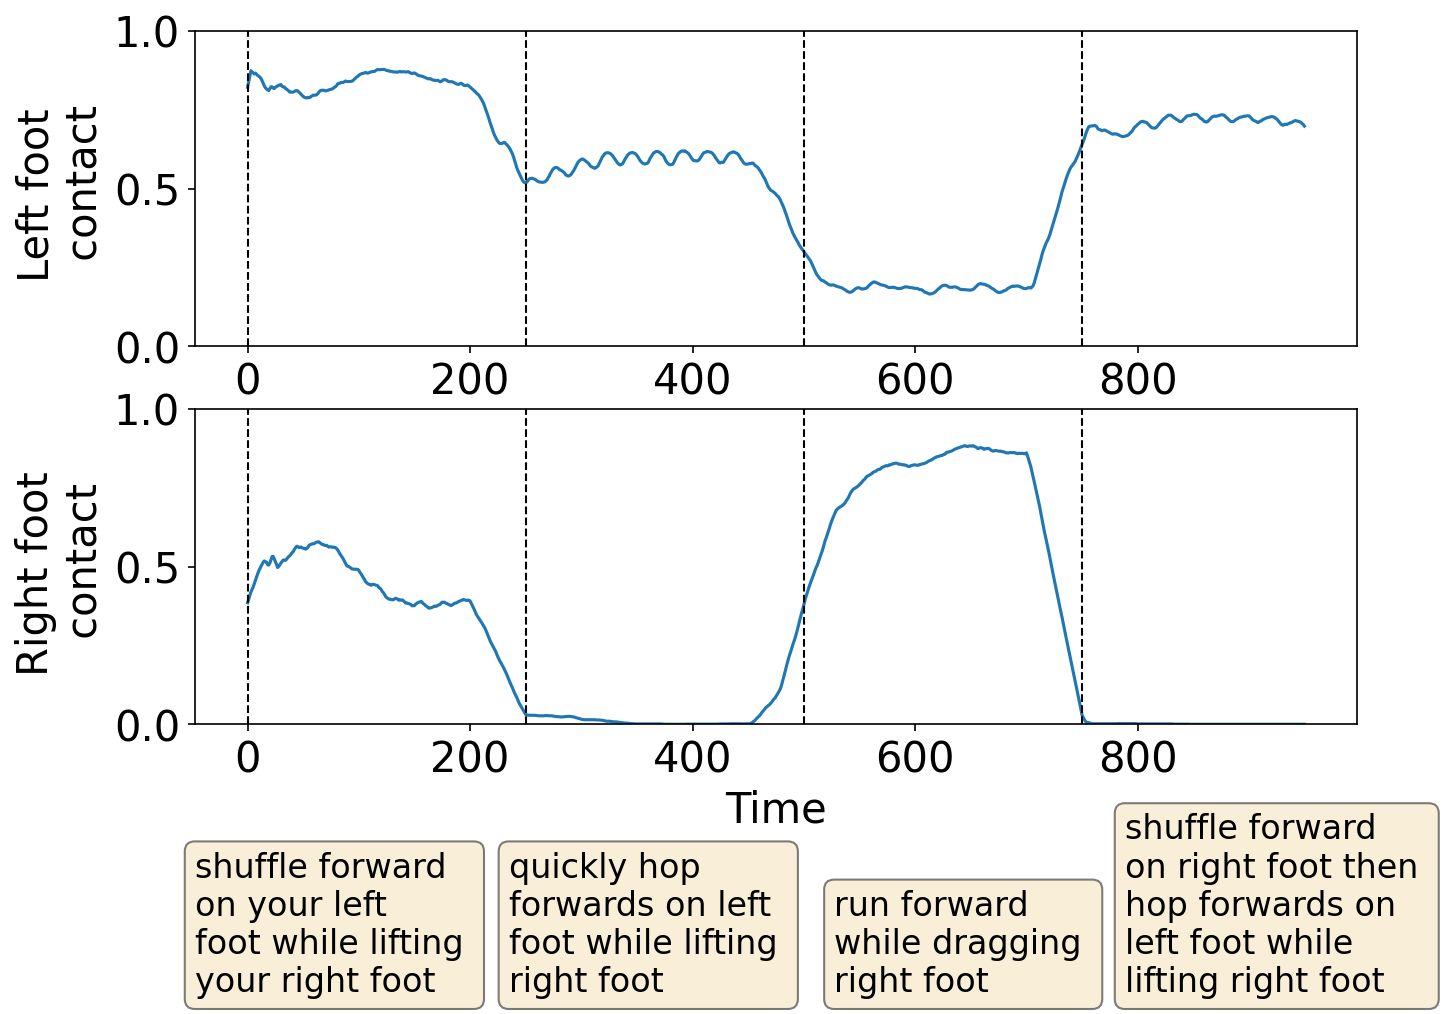

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
# plot reconstructed measures
ax1.plot(np.arange(0, len(moving_averages)), [moving_averages[i][0] for i in range(len(moving_averages))], label='Reconstructed')
ax2.plot(np.arange(0, len(moving_averages)), [moving_averages[i][1] for i in range(len(moving_averages))], label='Reconstructed')

# ax1.plot(np.arange(0, len(desired_measures)), [desired_measures[i][0] for i in range(len(desired_measures))], label='Desired')
# ax2.plot(np.arange(0, len(desired_measures)), [desired_measures[i][1] for i in range(len(desired_measures))], label='Desired')

ax1.set_ylabel('Left foot \n contact')#Measure 0
ax2.set_ylabel('Right foot \n contact')#Measure 1

ax1.set_xlabel('Time')
ax2.set_xlabel('Time')

# draw dotted vertical lines at the time intervals
for t in time_intervals:
        ax1.axvline(x=t[0], color='k', linestyle='--', linewidth=1)
        ax2.axvline(x=t[0], color='k', linestyle='--', linewidth=1)

# # ax1.legend()
# ax2.legend()
# # Shrink current axis's height by 10% on the bottom
# box = ax1.get_position()
# ax1.set_position([box.x0, box.y0 + box.height * 0.15,
#                  box.width, box.height * 0.85])
# box = ax2.get_position()
# ax2.set_position([box.x0, box.y0 + box.height * 0.15,
#                  box.width, box.height * 0.85])

# # Put a legend below current axis
# ax2.legend(loc='upper center', bbox_to_anchor=(0.45, -0.15),
#           fancybox=True, shadow=True, ncol=5)

labels = [
    "shuffle forward \non your left \nfoot while lifting \nyour right foot",
    "quickly hop \nforwards on left \nfoot while lifting \nright foot",
    "run forward \nwhile dragging \nright foot",
    "shuffle forward \non right foot then \nhop forwards on \nleft foot while \nlifting right foot"
]

# box style must have same height
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fs = 16

# # split labes into multiple lines, such that each line is at most 20 chars
# labels[0] = ' '.join(labels[0].split(' ')[:3]) + '\n' + ' '.join(labels[0].split(' ')[3:])
# labels[1] = ' '.join(labels[1].split(' ')[:3]) + '\n' + ' '.join(labels[1].split(' ')[3:])
# labels[2] = ' '.join(labels[2].split(' ')[:3]) + '\n' + ' '.join(labels[2].split(' ')[3:])
# labels[3] = ' '.join(labels[3].split(' ')[:3]) + '\n' + ' '.join(labels[3].split(' ')[3:])

# place a text box in upper left in axes coords
box_y = -0.85
ax2.text(0.0, box_y, labels[0], transform=ax2.transAxes, fontsize=fs,
        verticalalignment='baseline', bbox=props)
ax2.text(0.27, box_y, labels[1], transform=ax2.transAxes, fontsize=fs,
        verticalalignment='baseline', bbox=props)
ax2.text(0.55, box_y, labels[2], transform=ax2.transAxes, fontsize=fs,
        verticalalignment='baseline', bbox=props)
ax2.text(0.8, box_y, labels[3], transform=ax2.transAxes, fontsize=fs,
        verticalalignment='baseline', bbox=props)

# set y limits
ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])


In [ ]:
def behavior_composition_experiments(N: int = 20):
    '''Run N behavior composition experiments and report the results'''
    avg_rewards, avg_traj_lengths = [], []
    for n in range(N):
        measures = torch.rand((4, 2))
        print(f'Measures: {measures}')
        _, avg_rew, avg_traj_len = compose_behaviors(measures, multi_vec_env, device, multi_env_cfg.num_envs)
        avg_rewards.append(avg_rew),
        avg_traj_lengths.append(avg_traj_len)
        print(f'Completed trial {n + 1} of {N}')
    successes = [1 if x > 800 else 0 for x in avg_traj_lengths]
    success_rate = np.mean(successes)
    print(avg_rewards)
    print(avg_traj_lengths)
    print(success_rate)

In [ ]:
behavior_composition_experiments()